In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots appear inside the notebook
%matplotlib inline

# Load the raw data
df = pd.read_csv("../data_raw/LondonBikeJourneyAug2023.csv")

df.shape, df.columns

((776527, 11),
 Index(['Number', 'Start date', 'Start station number', 'Start station',
        'End date', 'End station number', 'End station', 'Bike number',
        'Bike model', 'Total duration', 'Total duration (ms)'],
       dtype='object'))

In [4]:
# Check column names just to be sure
print(df.columns.tolist())

# Look at a few raw values in the Start date column
print(df["Start date"].head())

# Convert to datetime (dayfirst because the dates are UK-style)
# errors="coerce" turns any weird values into NaT instead of crashing
df["Start date"] = pd.to_datetime(df["Start date"], dayfirst=True, errors="coerce")
df["End date"]   = pd.to_datetime(df["End date"],   dayfirst=True, errors="coerce")

# How many rows failed to parse?
print("Unparsed Start dates:", df["Start date"].isna().sum())
print("Unparsed End dates:", df["End date"].isna().sum())

# Drop any rows where we couldn't parse the dates
df = df.dropna(subset=["Start date", "End date"])

# Date and hour of day
df["date"] = df["Start date"].dt.date
df["hour"] = df["Start date"].dt.hour

# Day of week and weekend flag
df["day_of_week"] = df["Start date"].dt.day_name()
df["is_weekend"]  = df["day_of_week"].isin(["Saturday", "Sunday"])

df[["Start date", "date", "hour", "day_of_week", "is_weekend"]].head()


['Number', 'Start date', 'Start station number', 'Start station', 'End date', 'End station number', 'End station', 'Bike number', 'Bike model', 'Total duration', 'Total duration (ms)']
0    8/1/2023 0:00
1    8/1/2023 0:00
2    8/1/2023 0:00
3    8/1/2023 0:01
4    8/1/2023 0:01
Name: Start date, dtype: object
Unparsed Start dates: 479814
Unparsed End dates: 479914


,Start date,date,hour,day_of_week,is_weekend
0,2023-01-08 00:00:00,2023-01-08,0,Sunday,True
1,2023-01-08 00:00:00,2023-01-08,0,Sunday,True
2,2023-01-08 00:00:00,2023-01-08,0,Sunday,True
3,2023-01-08 00:01:00,2023-01-08,0,Sunday,True
4,2023-01-08 00:01:00,2023-01-08,0,Sunday,True


In [5]:
# Duration to minutes
df["duration_min"] = df["Total duration (ms)"] / (1000 * 60)

before = len(df)
df = df[df["duration_min"] > 0].dropna(subset=["duration_min"])
after = len(df)

print("Rows removed due to non-positive or missing duration:", before - after)
df["duration_min"].describe()


Rows removed due to non-positive or missing duration: 0


count    296413.000000
mean         22.089363
std         136.295573
min           0.021783
25%           7.966583
50%          13.730050
75%          22.698333
max       38644.998450
Name: duration_min, dtype: float64

In [6]:
daily = (
    df.groupby("date")
      .size()
      .rename("daily_hires")
      .reset_index()
)

daily_desc = daily["daily_hires"].describe()
daily_desc


count       12.000000
mean     24701.083333
std       5812.615159
min      11634.000000
25%      21190.500000
50%      25420.500000
75%      29879.250000
max      31792.000000
Name: daily_hires, dtype: float64

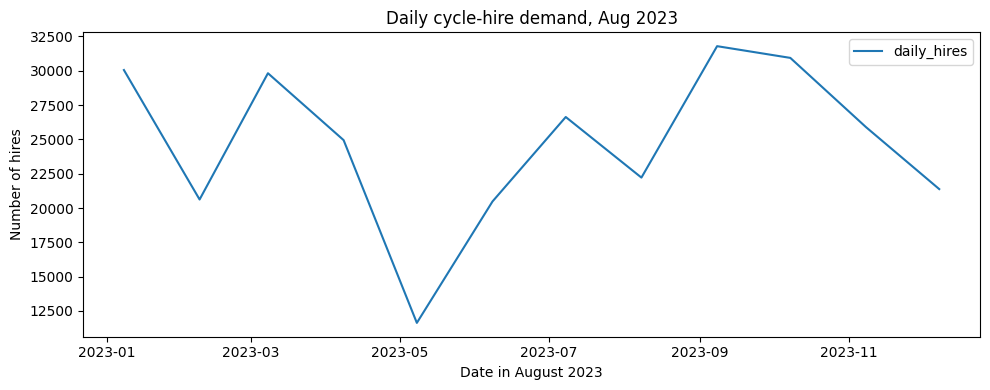

In [7]:
ax = daily.plot(x="date", y="daily_hires", kind="line", figsize=(10,4))
ax.set_xlabel("Date in August 2023")
ax.set_ylabel("Number of hires")
ax.set_title("Daily cycle-hire demand, Aug 2023")
plt.tight_layout()


In [8]:
hourly_profile = (
    df.groupby("hour")
      .size()
      .rename("total_hires")
      .reset_index()
)

n_days = df["date"].nunique()
hourly_profile["avg_hires"] = hourly_profile["total_hires"] / n_days

hourly_profile


,hour,total_hires,avg_hires
0,0,2975,247.916667
1,1,1754,146.166667
2,2,1167,97.250000
3,3,686,57.166667
4,4,794,66.166667
5,5,1666,138.833333
6,6,6415,534.583333
7,7,15873,1322.750000
8,8,26443,2203.583333
9,9,17319,1443.250000


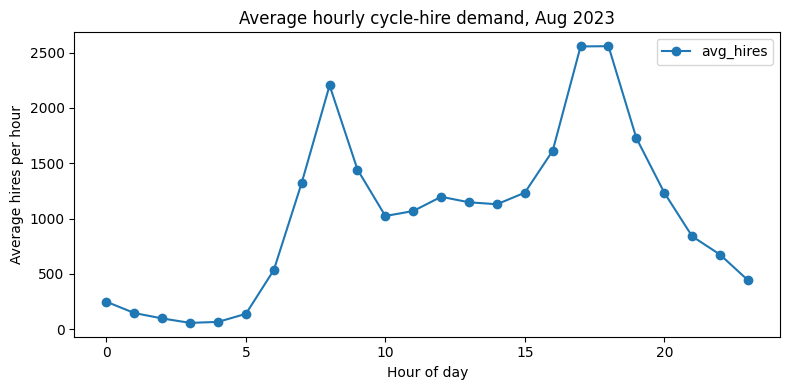

In [9]:
ax = hourly_profile.plot(x="hour", y="avg_hires", kind="line", marker="o", figsize=(8,4))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Average hires per hour")
ax.set_title("Average hourly cycle-hire demand, Aug 2023")
plt.tight_layout()


In [10]:
daily_week = (
    df.groupby(["date", "is_weekend"])
      .size()
      .rename("daily_hires")
      .reset_index()
)

weekday_daily = daily_week[daily_week["is_weekend"] == False]["daily_hires"]
weekend_daily = daily_week[daily_week["is_weekend"] == True]["daily_hires"]

print("Weekday mean:", weekday_daily.mean())
print("Weekend mean:", weekend_daily.mean())


Weekday mean: 22980.25
Weekend mean: 28142.75


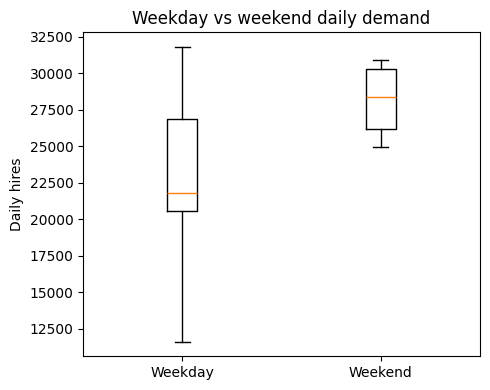

In [11]:
plt.figure(figsize=(5,4))
plt.boxplot([weekday_daily, weekend_daily], labels=["Weekday", "Weekend"])
plt.ylabel("Daily hires")
plt.title("Weekday vs weekend daily demand")
plt.tight_layout()


In [12]:
# Aggregate to hourly hire counts
hourly_counts = (
    df.groupby(["date", "hour"])
      .size()
      .rename("hire_count")
      .reset_index()
)

hourly_counts.head(), hourly_counts.shape


(         date  hour  hire_count
 0  2023-01-08     0         171
 1  2023-01-08     1         108
 2  2023-01-08     2          83
 3  2023-01-08     3          37
 4  2023-01-08     4          47,
 (288, 3))

In [13]:
hourly_counts["date"].min(), hourly_counts["date"].max(), hourly_counts["date"].nunique()


(datetime.date(2023, 1, 8), datetime.date(2023, 12, 8), 12)

In [14]:
import os
os.makedirs("../data_processed", exist_ok=True)
hourly_counts.to_csv("../data_processed/hourly_counts_2023_sample.csv", index=False)
